Model loaded successfully.
1/1 [==============================] - 2s 2s/step


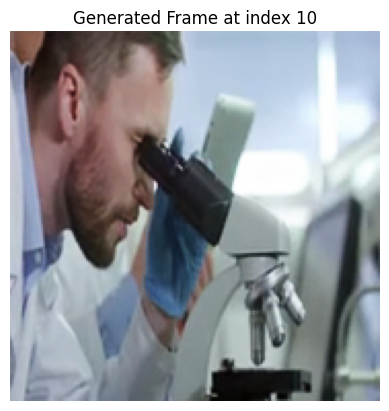

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Re-define the positional encoding function if necessary for loading the model
def positional_encoding(x, num_encoding_functions=6):
    encoding = [x]
    for i in range(num_encoding_functions):
        encoding.append(tf.sin((2.0 ** i) * np.pi * x))
        encoding.append(tf.cos((2.0 ** i) * np.pi * x))
    return tf.concat(encoding, axis=-1)

# Load the saved model (include the custom object for positional_encoding)
model = tf.keras.models.load_model('video_model.h5', custom_objects={'positional_encoding': positional_encoding})
print("Model loaded successfully.")

# Function to generate a frame from the loaded model
def generate_frame(loaded_model, frame_index, total_frames):
    # Normalize the index to [0,1]
    norm_index = np.array([[frame_index / (total_frames - 1)]], dtype=np.float32)
    pred_frame = loaded_model.predict(norm_index)
    pred_frame = np.clip(pred_frame[0], 0, 1)
    return (pred_frame * 255).astype(np.uint8)

# Example usage: Generate and display the frame at index 10
total_frames = 50  # as used during training
frame_to_generate = 10
generated_frame = generate_frame(model, frame_to_generate, total_frames)

plt.imshow(generated_frame)
plt.title(f"Generated Frame at index {frame_to_generate}")
plt.axis("off")
plt.show()


In [2]:
import cv2
import numpy as np
import tensorflow as tf

# --- Custom positional encoding function (same as used during training) ---
def positional_encoding(x, num_encoding_functions=6):
    encoding = [x]
    for i in range(num_encoding_functions):
        encoding.append(tf.sin((2.0 ** i) * np.pi * x))
        encoding.append(tf.cos((2.0 ** i) * np.pi * x))
    return tf.concat(encoding, axis=-1)

# --- Load the saved model with the custom object ---
model = tf.keras.models.load_model('video_model.h5', custom_objects={'positional_encoding': positional_encoding})
print("Model loaded successfully.")

# --- Video reconstruction parameters ---
total_frames = 50  # same number as during training
fps = 25           # frames per second for the output video

# --- Generate the first frame to obtain frame dimensions ---
norm_index = np.array([[0]], dtype=np.float32)
first_frame = model.predict(norm_index)
first_frame = np.clip(first_frame[0], 0, 1)
frame_height, frame_width, channels = first_frame.shape
print(f"Reconstructed frame dimensions: {frame_width}x{frame_height}")

# --- Initialize VideoWriter (using 'mp4v' codec) ---
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter('reconstructed_video.mp4', fourcc, fps, (frame_width, frame_height))

# --- Generate and write each frame ---
for i in range(total_frames):
    norm_index = np.array([[i / (total_frames - 1)]], dtype=np.float32)
    pred_frame = model.predict(norm_index)
    pred_frame = np.clip(pred_frame[0], 0, 1)
    
    # Convert frame to uint8 and from RGB to BGR (OpenCV expects BGR)
    frame = (pred_frame * 255).astype(np.uint8)
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    
    video_writer.write(frame_bgr)
    print(f"Frame {i+1}/{total_frames} written.")

video_writer.release()
print("Reconstructed video saved as 'reconstructed_video.mp4'.")


Model loaded successfully.
1/1 [==============================] - 0s 101ms/step
Reconstructed frame dimensions: 180x180
1/1 [==============================] - 0s 20ms/step
Frame 1/50 written.
1/1 [==============================] - 0s 14ms/step
Frame 2/50 written.
1/1 [==============================] - 0s 30ms/step
Frame 3/50 written.
1/1 [==============================] - 0s 30ms/step
Frame 4/50 written.
1/1 [==============================] - 0s 20ms/step
Frame 5/50 written.
1/1 [==============================] - 0s 24ms/step
Frame 6/50 written.
1/1 [==============================] - 0s 14ms/step
Frame 7/50 written.
1/1 [==============================] - 0s 31ms/step
Frame 8/50 written.
1/1 [==============================] - 0s 16ms/step
Frame 9/50 written.
1/1 [==============================] - 0s 16ms/step
Frame 10/50 written.
1/1 [==============================] - 0s 16ms/step
Frame 11/50 written.
1/1 [==============================] - 0s 14ms/step
Frame 12/50 written.
1/1 [========

GPU memory growth enabled.
180p video already exists, skipping conversion.
Extracted 10 high-res frames of shape 2160x3840.
Extracted 10 low-res frames of shape 180x320.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 320, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 320, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 320, 16)      2320      
                                                                 
 up_sampling2d (UpSampling2D  (None, 1080, 1920, 16)   0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 1080, 1920, 3)     435       
                       

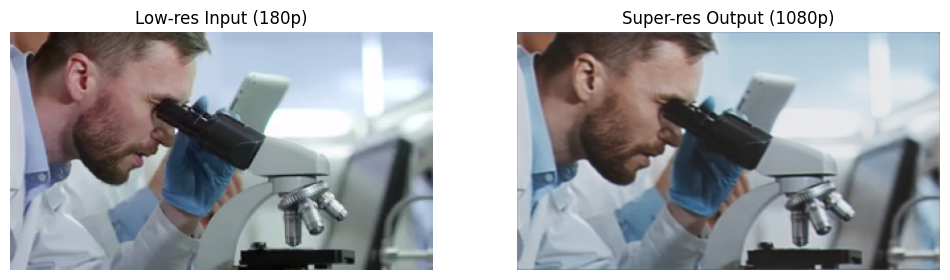

In [1]:
import os
import subprocess
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- GPU Memory Management ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)

# --- 1. Convert 2160p video to 180p using ffmpeg ---
lowres_video = "input_180p.mp4"
if not os.path.exists(lowres_video):
    print("Downscaling 2160p video to 180p... (ffmpeg is on the job)")
    cmd = [
        "ffmpeg",
        "-i", "./input.mp4",
        "-vf", "scale=-1:180",  # Downscale to 180p
        lowres_video
    ]
    subprocess.run(cmd, check=True)
else:
    print("180p video already exists, skipping conversion.")

# --- 2. Extract fewer frames (e.g., 10 instead of 50) to reduce memory usage ---
num_frames = 10  # Reduced number of frames

# Extract frames from the original 2160p video (high-res)
cap_hr = cv2.VideoCapture("./input.mp4")
hr_frames = []
frame_count = 0
while len(hr_frames) < num_frames:
    ret, frame = cap_hr.read()
    if not ret:
        break
    # Convert from BGR (OpenCV) to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    hr_frames.append(frame_rgb)
    frame_count += 1
cap_hr.release()
hr_frames = np.array(hr_frames, dtype=np.float32) / 255.0  # Normalize to [0, 1]
print(f"Extracted {hr_frames.shape[0]} high-res frames of shape {hr_frames.shape[1]}x{hr_frames.shape[2]}.")

# Resize ground truth frames to 1080p to match model output
hr_frames_resized = np.array([cv2.resize(frame, (1920, 1080)) for frame in hr_frames])

# Extract frames from the 180p video (low-res)
cap_lr = cv2.VideoCapture(lowres_video)
lr_frames = []
frame_count = 0
while len(lr_frames) < num_frames:
    ret, frame = cap_lr.read()
    if not ret:
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    lr_frames.append(frame_rgb)
    frame_count += 1
cap_lr.release()
lr_frames = np.array(lr_frames, dtype=np.float32) / 255.0  # Normalize to [0, 1]
print(f"Extracted {lr_frames.shape[0]} low-res frames of shape {lr_frames.shape[1]}x{lr_frames.shape[2]}.")

# --- 3. Build a simpler super-resolution model ---
input_shape = lr_frames.shape[1:]  # (180, 320, 3)
inputs = tf.keras.Input(shape=input_shape)

# Use fewer filters and layers to reduce memory usage
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)

# Upsample by a factor of 6 to match 1080p output
x = tf.keras.layers.UpSampling2D(size=(6, 6), interpolation='bilinear')(x)

# Final convolutional layer
outputs = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- 4. Train the model with a smaller batch size ---
epochs = 50  # Reduced number of epochs
batch_size = 2  # Smaller batch size to reduce memory usage
history = model.fit(lr_frames, hr_frames_resized, epochs=epochs, batch_size=batch_size, verbose=1)

# --- 5. Save the trained model ---
model_save_path = "super_res_model.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}.")

# --- 6. (Optional) Display a test upscale result ---
test_idx = 5  # Choose any frame index between 0 and num_frames-1
test_lr = lr_frames[test_idx:test_idx+1]  # shape: (1, 180, 320, 3)
pred_hr = model.predict(test_lr)
pred_hr = np.clip(pred_hr[0], 0, 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(test_lr[0])
plt.title("Low-res Input (180p)")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(pred_hr)
plt.title("Super-res Output (1080p)")
plt.axis("off")
plt.show()

In [1]:
import os
import subprocess
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- GPU Memory Management ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)

# --- 1. Convert 2160p video to 180p using ffmpeg ---
lowres_video = "input_180p.mp4"
if not os.path.exists(lowres_video):
    print("Downscaling 2160p video to 180p... (ffmpeg is on the job)")
    cmd = [
        "ffmpeg",
        "-i", "./input.mp4",
        "-vf", "scale=-1:180",  # Downscale to 180p
        lowres_video
    ]
    subprocess.run(cmd, check=True)
else:
    print("180p video already exists, skipping conversion.")

# --- 2. Extract fewer frames (e.g., 10 instead of 50) to reduce memory usage ---
num_frames = 10  # Reduced number of frames

# Extract frames from the original 2160p video (high-res)
cap_hr = cv2.VideoCapture("./input.mp4")
hr_frames = []
frame_count = 0
while len(hr_frames) < num_frames:
    ret, frame = cap_hr.read()
    if not ret:
        break
    # Convert from BGR (OpenCV) to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    hr_frames.append(frame_rgb)
    frame_count += 1
cap_hr.release()
hr_frames = np.array(hr_frames, dtype=np.float32) / 255.0  # Normalize to [0, 1]

# Resize high-res frames to 1080p to match model output
hr_frames_resized = np.array([cv2.resize(frame, (1920, 1080)) for frame in hr_frames])
print(f"Extracted {hr_frames_resized.shape[0]} high-res frames of shape {hr_frames_resized.shape[1]}x{hr_frames_resized.shape[2]}.")

# Extract frames from the 180p video (low-res)
cap_lr = cv2.VideoCapture(lowres_video)
lr_frames = []
frame_count = 0
while len(lr_frames) < num_frames:
    ret, frame = cap_lr.read()
    if not ret:
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    lr_frames.append(frame_rgb)
    frame_count += 1
cap_lr.release()
lr_frames = np.array(lr_frames, dtype=np.float32) / 255.0  # Normalize to [0, 1]
print(f"Extracted {lr_frames.shape[0]} low-res frames of shape {lr_frames.shape[1]}x{lr_frames.shape[2]}.")

# --- 3. Build a deeper super-resolution model ---
input_shape = lr_frames.shape[1:]  # (180, 320, 3)
inputs = tf.keras.Input(shape=input_shape)

# Initial convolutional layers
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# Add more convolutional layers to make the model deeper
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# Upsample by a factor of 6 to match 1080p output
x = tf.keras.layers.UpSampling2D(size=(6, 6), interpolation='bilinear')(x)

# Additional convolutional layers after upsampling
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# Final convolutional layer
outputs = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- 4. Train the model with a smaller batch size ---
epochs = 50  # Reduced number of epochs
batch_size = 2  # Smaller batch size to reduce memory usage
history = model.fit(lr_frames, hr_frames_resized, epochs=epochs, batch_size=batch_size, verbose=1)

# --- 5. Save the trained model ---
model_save_path = "super_res_model.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}.")

# --- 6. (Optional) Display a test upscale result ---
test_idx = 5  # Choose any frame index between 0 and num_frames-1
test_lr = lr_frames[test_idx:test_idx+1]  # shape: (1, 180, 320, 3)
pred_hr = model.predict(test_lr)
pred_hr = np.clip(pred_hr[0], 0, 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(test_lr[0])
plt.title("Low-res Input (180p)")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(pred_hr)
plt.title("Super-res Output (1080p)")
plt.axis("off")
plt.show()

GPU memory growth enabled.
180p video already exists, skipping conversion.
Extracted 10 high-res frames of shape 1080x1920.
Extracted 10 low-res frames of shape 180x320.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 320, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 320, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 320, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 320, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 320, 128)     147584    
                                                                 
 up_sampling2d (UpSampl

ResourceExhaustedError: Graph execution error:

Detected at node 'model/up_sampling2d/resize/ResizeBilinear' defined at (most recent call last):
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\anish\AppData\Local\Temp\ipykernel_12148\336937832.py", line 98, in <module>
      history = model.fit(lr_frames, hr_frames_resized, epochs=epochs, batch_size=batch_size, verbose=1)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\keras\layers\reshaping\up_sampling2d.py", line 146, in call
      return backend.resize_images(
    File "c:\Users\anish\anaconda3\envs\tf_env\lib\site-packages\keras\backend.py", line 3693, in resize_images
      x = tf.image.resize(x, new_shape, method=interpolations[interpolation])
Node: 'model/up_sampling2d/resize/ResizeBilinear'
OOM when allocating tensor with shape[2,1080,1920,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/up_sampling2d/resize/ResizeBilinear}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1032]